In [1]:
import pandas as pd

df_original = pd.read_csv('topRatedMovies.csv', delimiter=';', converters={
    "genres": lambda x: x.split("|"),
    "cast": lambda x: x.split("|")
})

df_original

,tmdb_id,title,year,runtime,rating,cast,genres
0,238,The Godfather,1972,175,87,"[Al_Pacino, Marlon_Brando, James_Caan, Richard...","[Drama, Crime]"
1,278,The Shawshank Redemption,1994,142,87,"[Tim_Robbins, Morgan_Freeman, Bob_Gunton, Will...","[Drama, Crime]"
2,240,The Godfather Part II,1974,202,86,"[Al_Pacino, Robert_Duvall, Diane_Keaton, Rober...","[Drama, Crime]"
3,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[Shah_Rukh_Khan, Kajol, Amrish_Puri, Anupam_Kh...","[Comedy, Drama, Romance]"
4,424,Schindler's List,1993,195,86,"[Liam_Neeson, Ben_Kingsley, Ralph_Fiennes, Car...","[Drama, History, War]"
...,...,...,...,...,...,...,...
495,266856,The Theory of Everything,2014,123,79,"[Eddie_Redmayne, Felicity_Jones, Charlie_Cox, ...","[Drama, Romance]"
496,56231,The Working Class Goes to Heaven,1971,113,79,"[Gian_Maria_Volonté, Mariangela_Melato, Salvo_...",[Drama]
497,549559,Apollo 11,2019,93,79,"[Neil_Armstrong, Buzz_Aldrin, Michael_Collins,...","[Documentary, History]"
498,152601,Her,2013,126,79,"[Joaquin_Phoenix, Scarlett_Johansson, Amy_Adam...","[Romance, Science_Fiction, Drama]"


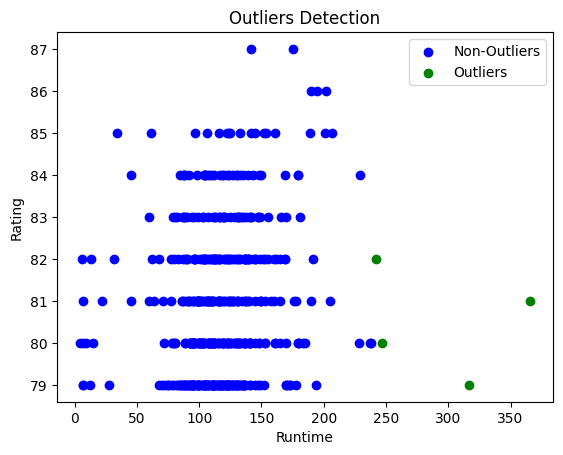

In [2]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

# Always base the outlier detection on the original data so that new outliers won't be detected on multiple runs
df = df_original.copy()

# Select the columns to perform the clustering on
df_cluster = df[['runtime', 'rating']]

# Set the threshold for outlier detection
threshold= 3

# Calculate the IQR
Q1 = df_cluster.quantile(0.25)
Q3 = df_cluster.quantile(0.75)
IQR = Q3 - Q1

# Identify the outliers based on the threshold
outliers = ((df_cluster < (Q1 - threshold * IQR)) | (df_cluster > (Q3 + threshold * IQR))).any(axis=1)
outlier_ids = df.loc[outliers, 'tmdb_id']

# Plot the outliers
plt.scatter(df_cluster.loc[~outliers, 'runtime'], df_cluster.loc[~outliers, 'rating'], c='blue', label='Non-Outliers')
plt.scatter(df_cluster.loc[outliers, 'runtime'], df_cluster.loc[outliers, 'rating'], c='green', label='Outliers')

plt.xlabel('Runtime')
plt.ylabel('Rating')
plt.title('Outliers Detection')
plt.legend()
plt.show()

In [3]:
# Drop the rows with outlier IDs
df = df[~df['tmdb_id'].isin(outlier_ids)].reset_index(drop=True)

df

,tmdb_id,title,year,runtime,rating,cast,genres
0,238,The Godfather,1972,175,87,"[Al_Pacino, Marlon_Brando, James_Caan, Richard...","[Drama, Crime]"
1,278,The Shawshank Redemption,1994,142,87,"[Tim_Robbins, Morgan_Freeman, Bob_Gunton, Will...","[Drama, Crime]"
2,240,The Godfather Part II,1974,202,86,"[Al_Pacino, Robert_Duvall, Diane_Keaton, Rober...","[Drama, Crime]"
3,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[Shah_Rukh_Khan, Kajol, Amrish_Puri, Anupam_Kh...","[Comedy, Drama, Romance]"
4,424,Schindler's List,1993,195,86,"[Liam_Neeson, Ben_Kingsley, Ralph_Fiennes, Car...","[Drama, History, War]"
...,...,...,...,...,...,...,...
491,266856,The Theory of Everything,2014,123,79,"[Eddie_Redmayne, Felicity_Jones, Charlie_Cox, ...","[Drama, Romance]"
492,56231,The Working Class Goes to Heaven,1971,113,79,"[Gian_Maria_Volonté, Mariangela_Melato, Salvo_...",[Drama]
493,549559,Apollo 11,2019,93,79,"[Neil_Armstrong, Buzz_Aldrin, Michael_Collins,...","[Documentary, History]"
494,152601,Her,2013,126,79,"[Joaquin_Phoenix, Scarlett_Johansson, Amy_Adam...","[Romance, Science_Fiction, Drama]"


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df[['rating', 'runtime']])

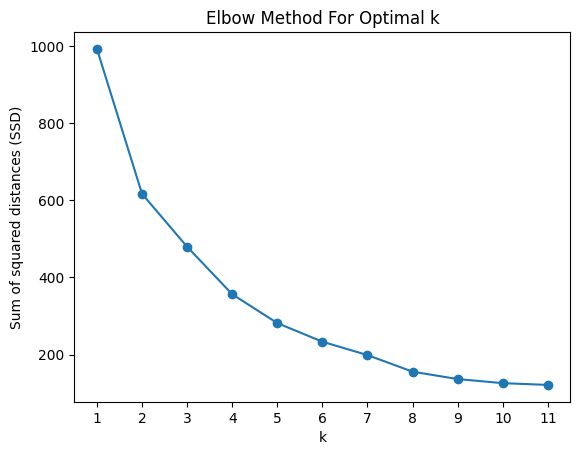

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate sum of squared distances
ssd = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(df_normalized)
    ssd.append(km.inertia_)
    
# Plot the elbow
plt.plot(K, ssd, 'o-')
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [6]:
# Perform clustering
kmeans = KMeans(n_clusters=4, n_init='auto')
predictions = kmeans.fit_predict(df_normalized)

# Add the cluster column to the original DataFrame
df['Cluster'] = predictions

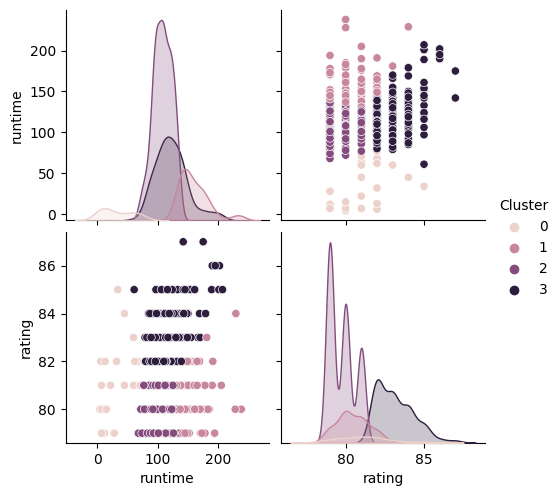

In [7]:
import seaborn as sns

sns.pairplot(df, vars=df_cluster, hue='Cluster')